# Libraries

In [44]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle as pkl
import time

# Cornac imports
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader as CornacReader #Reader exists in both packages
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, ItemKNN, UserKNN, BaselineOnly 
from cornac.models import NMF as CornacNMF #NMF exists in both packages
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

# # Surprise imports
# from surprise import BaselineOnly, KNNBasic, KNNWithMeans, SVDpp, SVD
# from surprise import NMF as SurpriseNMF
# from surprise import Dataset
# from surprise import Reader as SurpriseReader
# from surprise.model_selection import train_test_split
# from surprise import accuracy

from collections import defaultdict
from scipy import stats
from sklearn.metrics import mean_squared_error, precision_score, recall_score, ndcg_score, mean_absolute_error
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

In [2]:
import matplotlib

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

# Import results

In [3]:
algo_names = ["UserKNN",
              "ItemKNN", 
              "UserKNN with means", 
              "BPR",
              "MF",
              "PMF",
              "NMF",
              "WMF",
              "HPF",
              "NeuMF",
              "VAECF"
              ] # in the order that they are in the model list

In [4]:
results_location = "data/results/"

In [5]:
music_eva_two = pd.read_csv(results_location+"df_item_dist_cornac_music_eva_two.csv", index_col=0)

# Calculate correlation

In [6]:
music_eva_two_corr = pd.DataFrame(columns=["eva_two"], index = algo_names).fillna(0).copy()

In [7]:
music_eva_two_corr.head()

,eva_two
UserKNN,0
ItemKNN,0
UserKNN with means,0
BPR,0
MF,0


In [8]:
profile_pop = music_eva_two["count"]
i=0
for index, row in music_eva_two_corr.iterrows():
    algorithm=algo_names[i]
    rec_pop = music_eva_two[algorithm]
    correlation, _ = stats.pearsonr(profile_pop, rec_pop)
    music_eva_two_corr.loc[algorithm, "eva_two"] = correlation
    i+=1

In [9]:
music_eva_two_corr

,eva_two
UserKNN,0.65860437
ItemKNN,0.88810648
UserKNN with means,0.67316782
BPR,0.81919847
MF,0.90390485
PMF,0.62226973
NMF,0.75650410
WMF,0.81908174
HPF,0.83896069
NeuMF,0.83851837


In [10]:
algo_names

['UserKNN',
 'ItemKNN',
 'UserKNN with means',
 'BPR',
 'MF',
 'PMF',
 'NMF',
 'WMF',
 'HPF',
 'NeuMF',
 'VAECF']

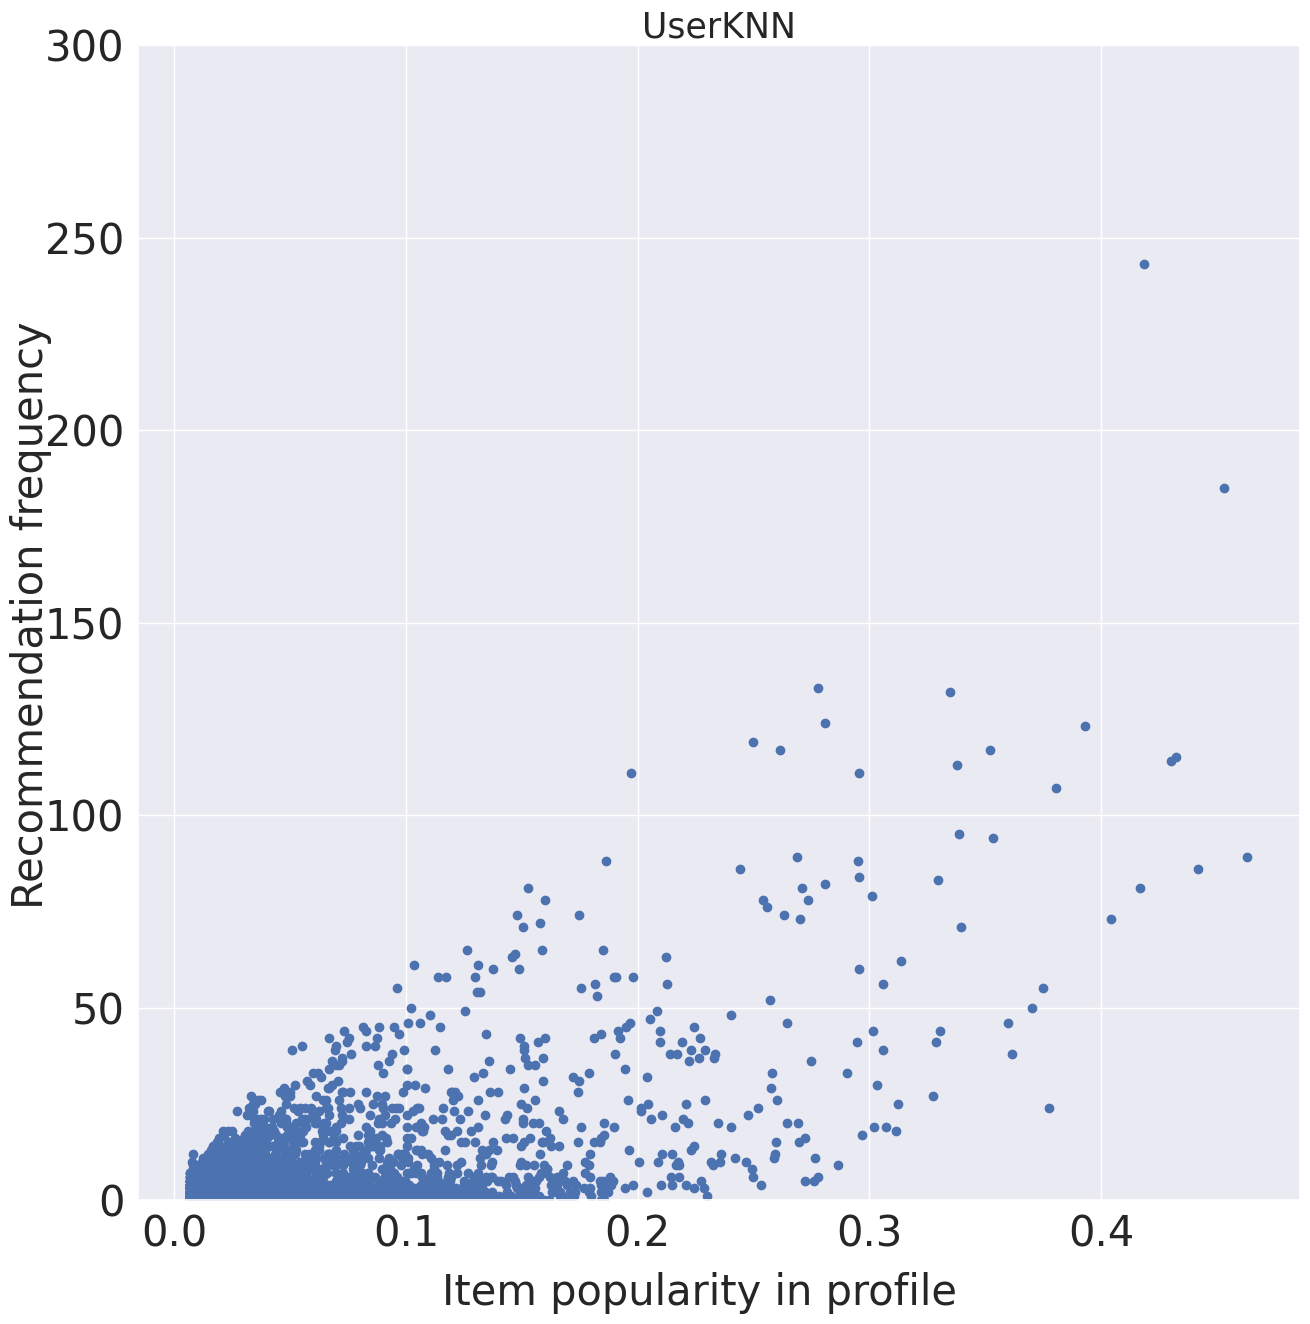

In [11]:
select_algo_names = ["UserKNN"]
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

fig.text(0.5, 0.04, 'Item popularity in profile', ha='center', fontsize='30')
fig.text(0.04, 0.5, 'Recommendation frequency', va='center', rotation='vertical', fontsize='30')
i = 0  
for algo in select_algo_names:
    profile_pop = music_eva_two["count"]
    alg_pop = music_eva_two[algo]
    correlation, _ = stats.pearsonr(profile_pop, alg_pop)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(profile_pop, alg_pop, "o")
    ax.set_ylim(0,300)
    ax.set_title(algo, fontsize='25')
    
    plt.savefig("graphs/"+algo+"_sampled_data_results.png")
    plt.show()

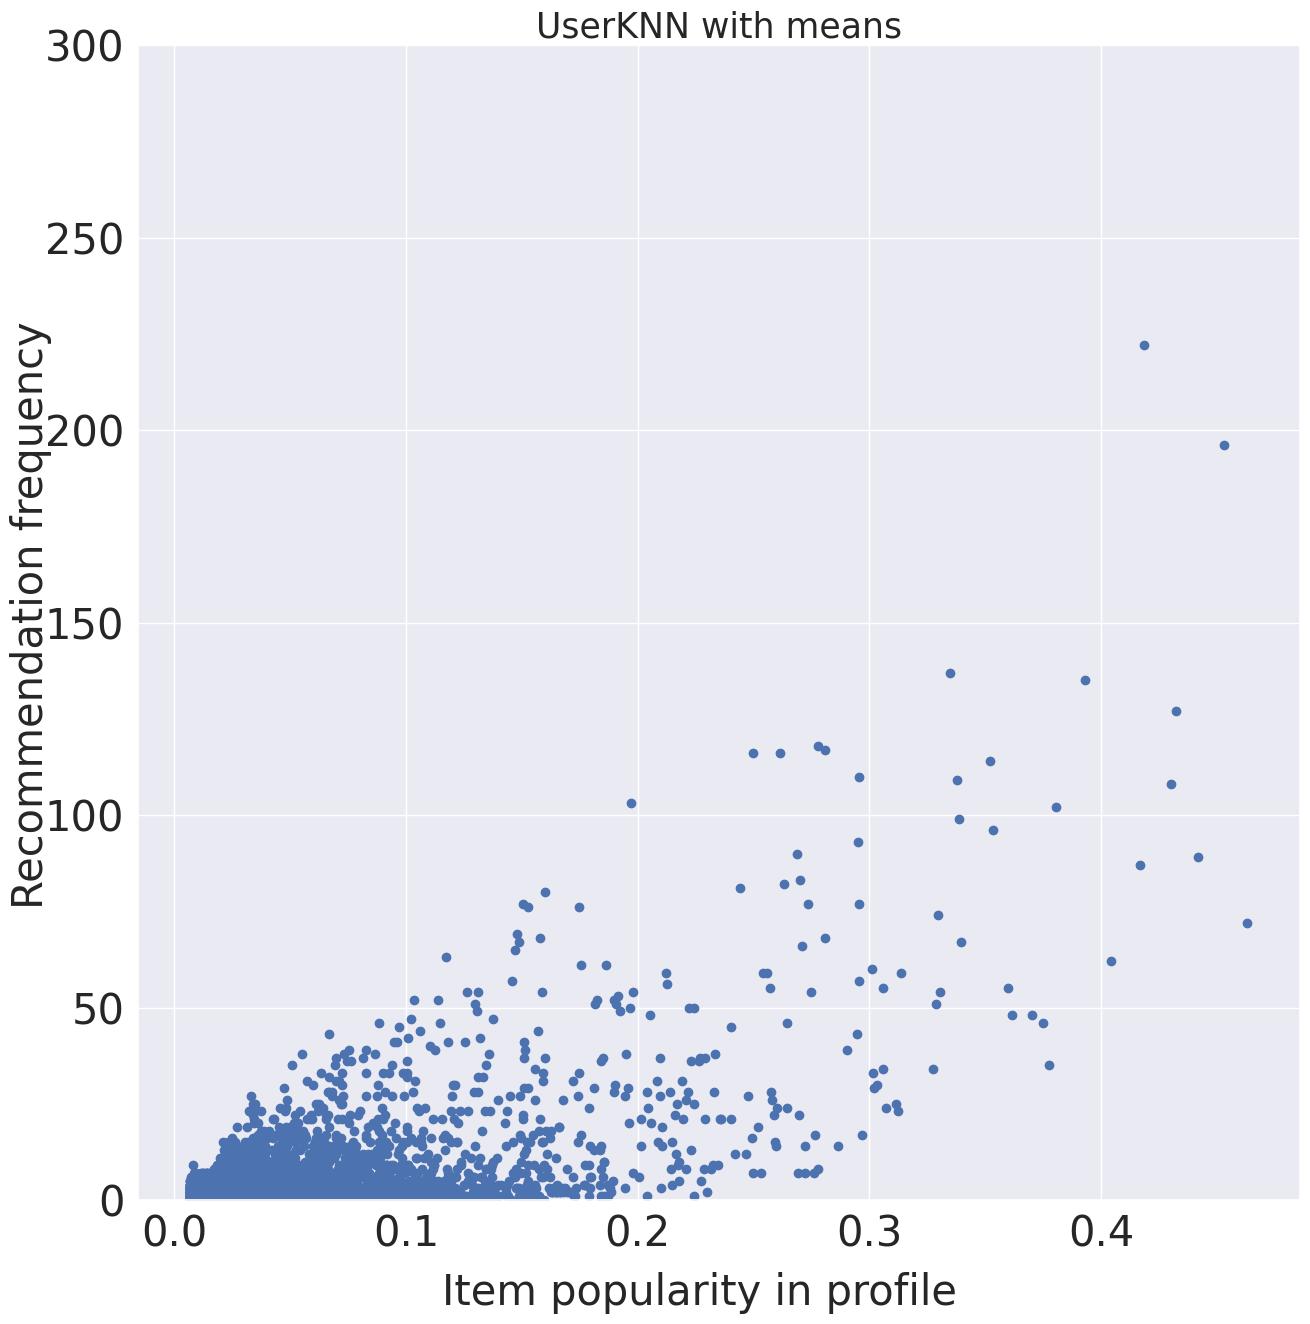

In [12]:
select_algo_names = ["UserKNN with means"]
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

fig.text(0.5, 0.04, 'Item popularity in profile', ha='center', fontsize='30')
fig.text(0.04, 0.5, 'Recommendation frequency', va='center', rotation='vertical', fontsize='30')
i = 0  
for algo in select_algo_names:
    profile_pop = music_eva_two["count"]
    alg_pop = music_eva_two[algo]
    correlation, _ = stats.pearsonr(profile_pop, alg_pop)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(profile_pop, alg_pop, "o")
    ax.set_ylim(0,300)
    ax.set_title(algo, fontsize='25')
    
    plt.savefig("graphs/"+algo+"_sampled_data_results.png")
    plt.show()

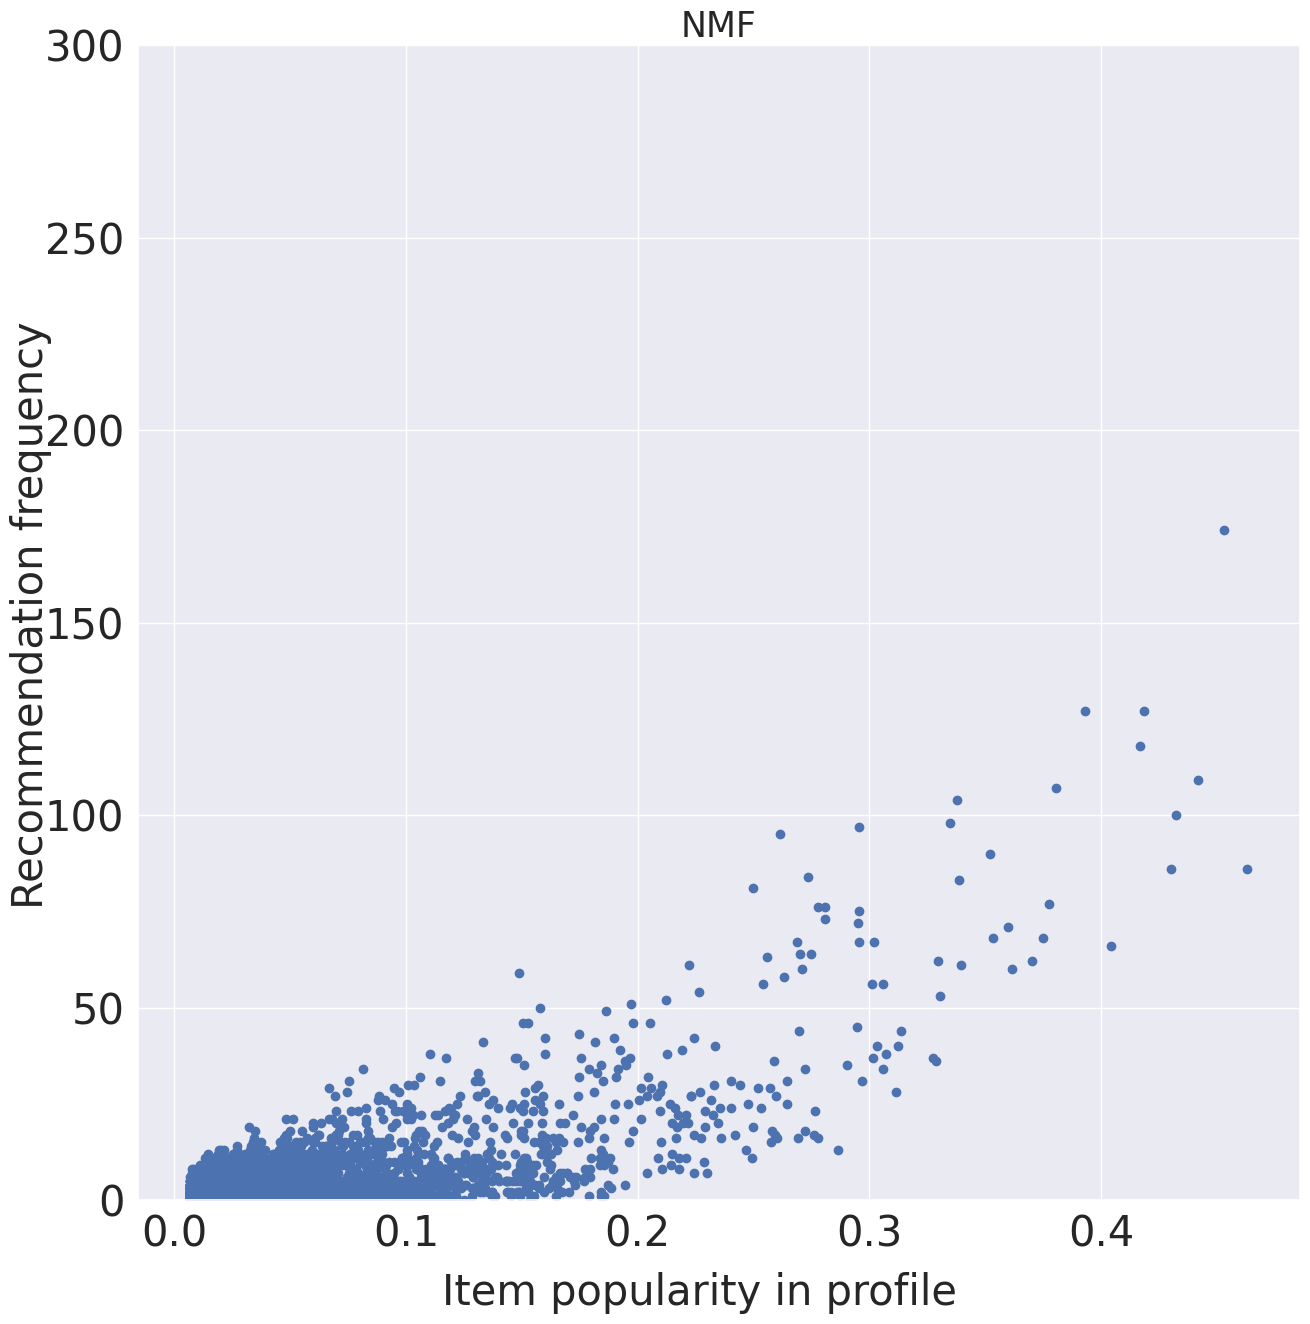

In [13]:
select_algo_names = ["NMF"]
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

fig.text(0.5, 0.04, 'Item popularity in profile', ha='center', fontsize='30')
fig.text(0.04, 0.5, 'Recommendation frequency', va='center', rotation='vertical', fontsize='30')
i = 0  
for algo in select_algo_names:
    profile_pop = music_eva_two["count"]
    alg_pop = music_eva_two[algo]
    correlation, _ = stats.pearsonr(profile_pop, alg_pop)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.plot(profile_pop, alg_pop, "o")
    ax.set_ylim(0,300)
    ax.set_title(algo, fontsize='25')
    
    plt.savefig("graphs/"+algo+"_sampled_data_results.png")
    plt.show()

# Compare MAE per user group

#### Usual run

In [14]:
# constants and initialization
rating_threshold = 1.0 # needed for the cornac library: Threshold used to binarize rating values into positive or negative feedback for model evaluation using ranking metrics (rating metrics are not affected). 
my_seed = 0
test_size = 0.2 # the percentage of "hold out" data that are used for testing
predict_col = "rating"
user_col = "user"
top_fraction = 0.2 # the amount of items that will be considered "popular"

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff

In [15]:
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/relevant_music_data_20.csv'
df_events = pd.read_csv(user_events_file, index_col=0)

In [16]:
item_col = "artist"


In [17]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

In [18]:
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 1008479
No. items: 12690
No. users: 3000


Mean artists per user: 336.2
Min artists per user: 4
Max artists per user: 2057


Mean users per artist: 79.5
Min users per artist: 21
Max users per artist: 1389




In [19]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item


In [20]:
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 2538


In [21]:
def read(low_user_file, medium_user_file, high_user_file):
    low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
    medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
    high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
    no_users = len(low_users) + len(medium_users) + len(high_users)
    print('No. of users: ' + str(no_users))
    
    mainstreaminess = "M_global_R_APC"
    
    print('Average mainstreaminess per user for low: ' + str(low_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for med: ' + str(medium_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for high: ' + str(high_users[mainstreaminess].mean()))
    return no_users, low_users, medium_users, high_users

In [22]:
def calculate_popularity_for_music(df_events, top_item_dist, item_dist, num_users, user_col, item_col, low_users, medium_users, high_users):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    low_profile_size = 0
    low_gap = 0
    medium_profile_size = 0
    medium_gap = 0
    high_profile_size = 0
    high_gap = 0
    low_ratio = 0
    medium_ratio = 0
    high_ratio = 0
    
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
    
        if u in low_users.index: # get user group-specific values
            low_profile_size += no_user_items
            low_gap += user_pop_item_fraq
            low_ratio += no_user_pop_items / no_user_items
        elif u in medium_users.index:
            medium_profile_size += no_user_items
            medium_gap += user_pop_item_fraq
            medium_ratio += no_user_pop_items / no_user_items
        else:
            high_profile_size += no_user_items
            high_gap += user_pop_item_fraq
            high_ratio += no_user_pop_items / no_user_items
        i+=1
        if i%1000==0:
            print(i)
    low_profile_size /= len(low_users)
    medium_profile_size /= len(medium_users)
    high_profile_size /= len(high_users)
    low_ratio /= len(low_users)
    medium_ratio /= len(medium_users)
    high_ratio /= len(high_users)
    low_gap /= len(low_users)
    medium_gap /= len(medium_users)
    high_gap /= len(high_users)
  
    return pop_count,user_hist,pop_fraq, pop_item_fraq, low_profile_size, medium_profile_size, high_profile_size, low_gap, medium_gap, high_gap, low_ratio, medium_ratio, high_ratio
def calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
        i+=1
        if i%1000==0:
            print(i)
    return pop_count,user_hist,pop_fraq, pop_item_fraq

In [23]:
def sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = "pop_fraq"):
    user_dist = user_dist.sort_index()
    user_dist_sorted = pd.DataFrame(data = user_dist)
    
    user_dist_sorted.columns = ["count"]
    
    user_dist_sorted["pop_count"] = pop_count
    user_dist_sorted["user_hist"] = user_hist
    user_dist_sorted["pop_fraq"] = pop_fraq
    user_dist_sorted["pop_item_fraq"] = pop_item_fraq
    
    user_dist_sorted = user_dist_sorted.sort_values(by=[by])
    return user_dist_sorted

def split(user_dist_sorted, top_fraction):
    low, med, high = np.split(user_dist_sorted, [int(top_fraction*len(user_dist_sorted)), int((1-top_fraction)*len(user_dist_sorted))])
    return low, med, high
def calculate_group_characteristics(low, med, high):
    low_profile_size = low.user_hist.mean()
    med_profile_size = med.user_hist.mean()
    high_profile_size = high.user_hist.mean()
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low.pop_item_fraq.mean()
    med_GAP = med.pop_item_fraq.mean()
    high_GAP = high.pop_item_fraq.mean()
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

In [24]:
popularity_function = {'pop_one': "pop_fraq",
             'pop_two': "pop_item_fraq" ,
             'pop_three': "mainstreaminess" }

In [25]:
pop_notion = "pop_three"

In [26]:
if pop_notion == "pop_three":
  low_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/low_main_users.txt"
  medium_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/medium_main_users.txt"
  high_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/high_main_users.txt"
  no_users, low, med, high= read(low_user_file, medium_user_file, high_user_file)
  pop_count,user_hist,pop_fraq, pop_item_fraq, low_profile_size, med_profile_size, high_profile_size, low_GAP, med_GAP, high_GAP, low_ratio, med_ratio, high_ratio = calculate_popularity_for_music(df_events, top_item_dist, item_dist, num_users, user_col, item_col, low, med, high)
  low_nr_users = 1000
  med_nr_users = 1000
  high_nr_users = 1000
else:
  pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col)
  user_dist_sorted = sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = popularity_function[pop_notion])
  low, med, high = split(user_dist_sorted, top_fraction)
  low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)


No. of users: 3000
Average mainstreaminess per user for low: 0.009333709599999998
Average mainstreaminess per user for med: 0.18199761010999999
Average mainstreaminess per user for high: 0.33798161341000005
1000
2000
3000


In [27]:
!pip install pandas==1.5

In [28]:
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):  
    scaler = MinMaxScaler(feature_range=(1, 1000)) #"βαθμολογια" 1 με 1000
    scaled_ratings = scaler.fit_transform(group[predict_col].values.reshape(-1, 1).astype(float))
    new_rows = group.copy()
    new_rows[predict_col] = scaled_ratings
    scaled_df_events = scaled_df_events.append(new_rows)

    #scaled_df_events = pd.concate([scaled_df_events,pd.DataFrame([new_rows])])

In [29]:
df_events_cornac = df_events.copy()
mapping_dict = {} # Create a dictionary that maps each artist to an integer.
i=0
for art in df_events_cornac[item_col].unique():
    mapping_dict[art] = i
    i+=1
df_events_cornac[item_col] = df_events_cornac[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [30]:
df_events_cornac.user = df_events_cornac.user.astype("string")
df_events_cornac.artist = df_events_cornac.artist.astype("string")

In [31]:
df_item_dist_cornac = df_item_dist.rename(index = mapping_dict)

In [32]:
data = list(df_events_cornac[[user_col,item_col,predict_col]].to_records(index = False))

In [33]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=0)

In [34]:
all_items = set(range(rs.total_items)) # needed for later

In [35]:
# Define the two different options for UserKNN, with and without mean centering
usKNN = UserKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True)
usKNN_means = UserKNN(k=40, similarity = 'cosine', mean_centered=True, seed = my_seed, verbose=True)

In [36]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 3: UserKNN
          usKNN,
          # 5: UserKNN with means
          usKNN_means,
          # 10: NMF
          CornacNMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          ]

In [37]:
algo_names = [
              "UserKNN",
              
              "UserKNN with means", 
              
              "NMF",
              
              ] # in the order that they are in the model list

In [38]:
# define metrics to evaluate the models
metrics = [MAE()]

# put it together in an experiment, voilà!
start = time.time()
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()
end = time.time()
print(round(end-start), "seconds.")

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!

TEST:
...
        |     MAE | Train (s) | Test (s)
------- + ------- + --------- + --------
UserKNN | 47.7393 |    1.6708 |  28.8057
UserKNN | 48.1996 |    1.5590 |  28.6220
NMF     | 44.7667 |    2.9934 |   3.3489

67 seconds.


In [39]:
def get_top_n_eva_two(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_test_set = rs.test_set.user_data[uid][0] 
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_in_the_test_set)[0] # items the user has rated in the test set 
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      if isinstance(model.score(uid, iid), (np.ndarray)): # for NEUMF
            score = model.score(uid, iid)[0]
      else:
            score = model.score(uid, iid)
        
      top_n[int(user_id)].append((int(item_id), score))
      
  return top_n

In [41]:
evaluation_function = {'eva_two': get_top_n_eva_two}

In [42]:
choice = 'eva_two'
# to be manually set!!! 

In [43]:
algo_dict = {}
for i in range(0, len(algo_names)):
    top_n = evaluation_function[choice](algo_names[i],i, n=10)
    algo_dict[algo_names[i]] = top_n.items()


UserKNN model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:05<00:00, 12.24it/s]


UserKNN with means model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:05<00:00, 12.24it/s]


NMF model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:04<00:00, 46.31it/s]


#### MAE per group

In [46]:
def calculate_MAE_per_group(algo_name,i):
    model = exp.models[i]
    print(algo_name + " model is selected:")
    
    mae_low = 0.0
    mae_med = 0.0
    mae_high = 0.0
    
    nr_low = 0.0
    nr_med = 0.0
    nr_high = 0.0
    
    for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_test_set = rs.test_set.user_data[uid][0]
        item_ids = [list(model.train_set.item_ids)[test_item] for test_item in user_items_in_the_test_set]
        real_scores = df_events_cornac[(df_events_cornac.user==user_id)&(df_events_cornac[item_col].isin(item_ids))]['rating'].values
        pred_scores = []
        j=0
        for test_item in user_items_in_the_test_set:
            item_score = model.score(user_idx=uid, item_idx=test_item)
            pred_scores.append(item_score)

        user_mae = mean_absolute_error(real_scores, pred_scores)
        
        if int(user_id) in low.index: # some issue with string vs integer
            mae_low+=user_mae
            nr_low += 1
        elif int(user_id) in med.index:
            mae_med+=user_mae
            nr_med += 1
        elif int(user_id) in high.index:
            mae_high+=user_mae
            nr_high += 1
        else:
          print("hi")
        j+=1
    mae_low/=nr_low
    mae_med/=nr_med
    mae_high/=nr_high
    return mae_low, mae_med, mae_high

In [47]:
MAEs = pd.DataFrame(index = algo_names, columns = ['low','med','high']).fillna(0.0)
for i in range(0, len(algo_names)):
    MAEs.loc[algo_names[i]] = calculate_MAE_per_group(algo_names[i], i)


UserKNN model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [12:19<00:00,  4.06it/s]


UserKNN with means model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [12:18<00:00,  4.06it/s]


NMF model is selected:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [11:53<00:00,  4.20it/s]


In [48]:
MAEs

,low,med,high
UserKNN,53.88324515,39.59466446,57.98741943
UserKNN with means,54.14303622,40.12203916,58.65697092
NMF,46.57408315,36.21100409,56.38245067
